# Earth Lab Capstone Project: Where can soil moisture improve rainfall-triggered landslide predictability?

## Author: Jacquelyn Witte

## This Notebook examines the relationship between SMAP and ESA CCI soil moisture and GPM precipitation for Landslides in the US

- Based on Landslide events from the NASA Global Landslide Catalog
- Using Landslide locations over Colorado as a workflow example

In [1]:
# Override saving plots
GLOBAL_CACHE_OVERRIDE = False

In [87]:
import os
from glob import glob

import datetime as dt
import earthpy as et
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as st
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.2)

In [3]:
def read_smap(filepath, index):
    """
    Reads SMAP data and returns the variable of interest.
    
    Parameters
    ----------
    filepath: Str
        File path of a SMAP L3 HDF5 file
        
    group_id: String
        Groups within the file to access
        
    index: int
        Index associated with the variable to retrieve
    
    Returns
    -------
    data: 2D numpy.ndarray (lat, lon)
    date: Date String yyyymmdd
    """
    # Read the file
    group_id = 'Soil_Moisture_Retrieval_Data_PM'
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        data_id = list(f[group_id].keys())[index]
        data = f[group_id][data_id][:,:]
        data[data == f[group_id][data_id].attrs['_FillValue']] = np.nan
        
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[5]
        yyyy = int(yyyymmdd[0:4])
        mm = int(yyyymmdd[4:6])
        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return data, date

In [4]:
def findfile(input_files, input_date):
    """
    Returns a single file from a list of files
    
    Parameters
    ----------
    input_files: List of strings
        List of full path to the file
        
    input_date: String
        YYYYMMDD format
        
    Returns
    -------
    file: Str
    """
    file = [x for x in input_files if re.findall(input_date, x)]
    if not file:
        raise ValueError('File does not exist for '+input_date)
    return file

In [32]:
def nearestneighbor_ncdf(input_file, parameter, loc):
    """
    Extracts nearest neighbor value based on location and desired parameter. 
    
    Parameters
    ----------   
    input_file: Str - full path to a single file
    
    parameter: Str 
    
    loc: tuple (degree longtitude, degree latitude)
    
    Returns
    -------
    float
    """
    # read the netcdf file
    try:
        data_xr = xr.open_dataset(input_file).squeeze()
    except IOError:
        print("This file is not accessible: "+input_file)
    finally:
        data_xr.close()
    
    # subset the file
    res = data_xr[parameter].sel(indexers={
            'lon': loc[0],
            'lat': loc[1]},
            method="nearest")
    
    return float(res.values)

In [89]:
def leastsq(x, y, method=3):
    """
    5 methods to compute least squares fit.

    Reference: https://github.com/sbird/spb_common/blob/master/leastsq.py
    Compute the least squares fit to y = beta x + alpha,
    using one of the 5 methods outlined in
    http://adsabs.harvard.edu/abs/1990ApJ...364..104I
    Method 1 minimises distance from Y given X (ie, the standard least squares fit)
    Method 2 minimises distance from X given Y
    Method 3 (recommended) is the OLS bisector, which gives a line bisecting the above two.
    Method 4 (Orthogonal regression) minimises perpendicular distance from the line to points
    Method 5 is the geometric mean of the slopes from methods 1 and 2.
    Method 6 is the Theil-Sen estimator: the median of the pairwise slopes.
    (See Akritas 95,  http://www.tandfonline.com/doi/abs/10.1080/01621459.1995.10476499)

    Parameters
    ----------
    x, y: numeric array

    Returns
    -------
    (alpha, beta, bvar), the intercept slope and variance of the slope
    """
    # Define some sums
    xbar = np.mean(x)
    ybar = np.mean(y)
    xdif = x-xbar
    ydif = y-ybar
    sxx = np.sum(xdif**2)
    syy = np.sum(ydif**2)
    sxy = np.sum(ydif*xdif)

    # Check for zeros
    if sxx == 0 or syy == 0 or sxy == 0:
        raise ValueError("Least Squares ill-defined")
    if method > 6 or method < 1:
        raise ValueError("Method not recognised")

    # These formulas are taken from Table 1 of Isobe et al, page 3
    # Minimise distance from Y given X
    beta1 = sxy/sxx
    # Variance of b1
    bvar1 = np.sum(xdif**2*(ydif-beta1*xdif)**2)/sxx**2
    # Minimise distance from X given Y
    beta2 = syy/sxy
    # Variance of b2
    bvar2 = np.sum(ydif**2*(ydif-beta2*xdif)**2)/sxy**2
    # Covariance of b1 and b2
    covb12 = np.sum(xdif*ydif*(ydif-beta2*xdif) *
                    (ydif-beta1*xdif))/(beta1*sxx**2)

    if method == 1:
        beta = beta1
        bvar = bvar1
    if method == 2:
        beta = beta2
        bvar = bvar2
    if method == 3:
        # OLS bisector: line that bisects the above two.
        beta1p1 = 1+beta1**2
        beta2p1 = 1+beta2**2
        beta = (beta1*beta2 - 1 + np.sqrt(beta1p1*beta2p1))/(beta1+beta2)
        # Variance
        prefac = beta**2 / ((beta1 + beta2)**2 * beta1p1 * beta2p1)
        var = (beta2p1**2 * bvar1 + 2 * beta1p1 * beta2p1 
               * covb12 + beta1p1**2 * bvar2)
        bvar = prefac*var

    if method == 4:
        # Orthogonal: minimise perpendicular distance from line to points
        beta = 0.5*((beta2-1./beta1)+np.sign(sxy) *
                    np.sqrt(4+(beta2-1./beta1)**2))
        prefac = beta**2 / (4*beta1**2 + (beta1*beta2 - 1)**2)
        bvar = prefac * (bvar1/beta1**2 + 2*covb12 + beta1**2*bvar2)

    if method == 5:
        # Reduced major axis:
        beta = np.sign(sxy)*np.sqrt(beta1*beta2)
        bvar = 0.25 * (beta2/beta1 * bvar1 + 2*covb12 + beta1/beta2 * bvar2)

    if method == 6:
        # Theil-Sen estimator for uncensored data: the median of the slopes.
        yy = np.subtract.outer(y, y)
        xx = np.subtract.outer(x, x)
        ind = np.where(xx != 0)
        beta = np.median(yy[ind]/xx[ind])
        # Can't find a formula for the variance
        bvar = 0

    # The intercept
    alpha = ybar - beta*xbar

    return (alpha, beta, bvar)

### Choose the state 

In [6]:
westernUS = ['Colorado', 'California', 'Oregon', 'Washington']
state = westernUS[0]

### Read and subset to Colorado Landslides >= year 2015 (SMAP data starts in 2015)

In [7]:
# Read the GLC file
glc_file = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 
                        'landslide', 'nasa_global_landslide_catalog_point.csv')

glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') 
             & (glc['admin_division_name'] == state) 
             & (glc['landslide_trigger'] != 'freeze_thaw') 
             & (glc['landslide_trigger'] != 'snowfall_snowmelt') 
             & (glc['landslide_trigger'] != 'earthquake') 
             & (glc['landslide_trigger'] != 'leaking_pipe') 
             & (glc['landslide_trigger'] != 'no_apparent_trigger') 
             & (glc['landslide_trigger'] != 'other')              
             & (glc['landslide_trigger'] != 'unknown')
            ]
# convert to pandas datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co_gt2015 = glc_co[glc_co.index > '2015-04-01']

print(glc_co_gt2015.shape)
print(np.unique(glc_co_gt2015['landslide_trigger']))
print(np.unique(glc_co_gt2015['landslide_category']))
print(glc_co_gt2015.columns)
glc_co_gt2015.tail()

(39, 31)
['continuous_rain' 'downpour' 'rain']
['debris_flow' 'landslide' 'mudslide' 'rock_fall']
Index(['OBJECTID', 'Shape', 'source_name', 'source_link', 'event_id',
       'event_date', 'event_time', 'event_title', 'event_description',
       'location_description', 'location_accuracy', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'fatality_count', 'injury_count', 'storm_name', 'photo_link',
       'comments', 'event_import_source', 'event_import_id', 'latitude',
       'longitude', 'country_name', 'country_code', 'admin_division_name',
       'gazetteer_closest_point', 'gazetteer_distance', 'submitted_date',
       'last_edited_date'],
      dtype='object')


,OBJECTID,Shape,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,...,event_import_id,latitude,longitude,country_name,country_code,admin_division_name,gazetteer_closest_point,gazetteer_distance,submitted_date,last_edited_date
date,,,,,,,,,,,,,,,,,,,,,
2018-07-18 22:43:18,7994040,"(-107.87244311899997, 37.28532144900004)",KOB,https://www.kob.com/new-mexico-news/repairs-un...,14410,2018-07-18 22:43:18,unknown,Durango and Silverton Narrow Gauge Railroad Mu...,Rain that followed the 416 Fire caused mudslid...,Durango and Silverton Narrow Gauge Railroad Mu...,...,NaN,37.285321,-107.872443,United States,US,Colorado,Durango,1.28,2020-08-12 22:43:18,2022-04-23 06:23:19
2018-07-28 04:00:00,7970459,"(-107.08545235999998, 39.43125291500007)",Post Independent,https://www.postindependent.com/news/lake-chri...,13828,2018-07-28 04:00:00,13:00,El Jebel Minor Debris Flow,"A minor debris flow was reported in El Jebel, ...","El Jebel, Colorado",...,NaN,39.431253,-107.085452,United States,US,Colorado,Basalt,8.40,2020-04-23 12:37:26,2022-04-23 06:31:41
2018-08-02 23:12:19,7983626,"(-107.88065523199998, 37.27698773100008)",The Durango Herald,https://durangoherald.com/articles/234830,14105,2018-08-02 23:12:19,15:00,416 Burn Area Mudslides,Mudslides in the area of the 416 burn area hav...,"La Plata County, CO from honeyville to East An...",...,NaN,37.276988,-107.880655,United States,US,Colorado,Durango,0.60,2020-05-01 23:12:19,2022-04-23 06:40:35.000001
2019-07-29 00:00:00,8000732,"(-107.272192, 39.567403)",Denver Post,https://www.denverpost.com/2019/07/27/mudslide...,1111,7/29/19 0:00,NaN,I-70 Glenwood Springs Mudslide,blocked road in multiple places,Glenwood Springs,...,1111,39.567403,-107.272192,United States,US,Colorado,Glenwood Springs,1.00,5/14/22 0:00,28:10.0
2020-07-27 12:00:00,7997906,"(-107.76327806699999, 37.920565743000054)",CBS Denver,https://denver.cbslocal.com/2020/07/27/telluri...,14232,2020-07-27 12:00:00,12:00,Telluride mudslide leaves hikers stranded.,Over 40 people temporarily stranded by mudslid...,"2-4074 Black Bear Pass Rd, Telluride, Colorado...",...,NaN,37.920566,-107.763278,United States,US,Colorado,Telluride,7.03,2020-08-04 18:52:35,2022-04-23 06:26:05


### Get all SMAP, ESA and GPM data files, sorted
 - ESA = Percent of Saturation Soil Moisture
 - SMAP = Volumetric soil moisture in cm3/cm3
 - GPM = Precipitation accumulation in mm

In [8]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone')
smap_files = sorted(glob(os.path.join(data_dir, 'smap_9km', '*.h5')))

gpm_files = sorted(glob(os.path.join(data_dir, 'gpm_westernUS', '*nc4')))

esa_files = sorted(glob(os.path.join(data_dir, 'esa_soil_moisture', 
                                     '*ACTIVE*nc')))

# Print a sample as a sanity check
print(os.path.exists(smap_files[0]))
print(os.path.exists(gpm_files[0]))
print(os.path.exists(esa_files[0]))

True
True
True


#### These are SMAP variables that can provide key information in characterizing landslides over Colorado

| Variable Name | Index | Units |
| ----------- | ----------- | ----------- |
| soil_moisture | 24 | cm<sup>3</sup>/cm<sup>3</sup> |
| radar_water_body_fraction | 15 | N/A | 
| vegetation_opacity | 46 | N/A |
| vegetation_water_content | 50 | kg/m<sup>2</sup> |

### Load the EASE2 grid lon and lat datasets to subset SMAP data. 
- These can be found on the NSIDC website: https://nsidc.org/data/ease/tools#geo_data_files

> Brodzik, M. J., B. Billingsley, T. Haran, B. Raup, M. H. Savoie. 2012. EASE-Grid 2.0: Incremental but Significant Improvements for Earth-Gridded Data Sets. ISPRS International Journal of Geo-Information, 1(1):32-45, doi:10.3390/ijgi1010032. http://www.mdpi.com/2220-9964/1/1/32.

In [9]:
# Reshape to dimensions of the SMAP data above
sm_data, date = read_smap(smap_files[1], 24)

lats = np.fromfile(os.path.join(data_dir, 'smap_9km',
                                'EASE2_M09km.lats.3856x1624x1.double'),
                   dtype=np.float64).reshape(sm_data.shape)
lons = np.fromfile(os.path.join(data_dir, 'smap_9km',
                                'EASE2_M09km.lons.3856x1624x1.double'),
                   dtype=np.float64).reshape(sm_data.shape)
sm_data.shape

(1624, 3856)

### Read the SMAP, ESA CCI and GPM data 
- Two dataframes are generated
    1. Colocated to all the Landslide events
    2. Precipitation measurements going back 7 day from each landslide event and indexed to Landslide ID

In [44]:
precip7d_date = []
precip7d = []
precip_accum = []
smap_sm = []
smap_wc = []
esa_sm = []
landslide_date = []
landslide_id = []
landslide7d_id = []
landslide_cat = []
landslide_trig = []
landslide_sz = []
lat = []
lon = []
periods = 7
count_down = []

for i, ls_date in enumerate(glc_co_gt2015.index):
#for i, ls_date in enumerate(glc_co_gt2015.index[1:len(glc_co_gt2015.index)]):

    # Get -7 days from the event
    glc_date = pd.date_range(ls_date, periods=periods,
                             freq='-1D').strftime('%Y%m%d')

    # Append landslide metadata
    landslide_date.append(ls_date)
    lat.append(glc_co_gt2015.latitude[i])
    lon.append(glc_co_gt2015.longitude[i])
    landslide_id.append(glc_co_gt2015.event_id[i])
    landslide_cat.append(glc_co_gt2015.landslide_category[i])
    landslide_trig.append(glc_co_gt2015.landslide_trigger[i])
    landslide_sz.append(glc_co_gt2015.landslide_size[i])

    # Take the +/- 0.3 deg mean around the Landslide event
    N_lat = glc_co_gt2015.latitude[i]+0.15
    S_lat = glc_co_gt2015.latitude[i]-0.15
    W_lon = glc_co_gt2015.longitude[i]-0.15
    E_lon = glc_co_gt2015.longitude[i]+0.15
    subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)

    #print(i, ls_date, glc_co_gt2015.latitude[i], glc_co_gt2015.longitude[i])
    
    # Initialize data
    sm_mean = []
    vegwc_mean = []
    esa_mean = []
    precip = []
    countd = periods
 
    # loop over the 7 days
    for yyyymmdd in glc_date:
        
        # Find the SMAP file
        filesm = findfile(smap_files, yyyymmdd)
        # Retrieve the SMAP variables
        sm, time_t = read_smap(filesm[0], 24)
        vegwc, t = read_smap(filesm[0], 50)
        # Calculate the SMAP mean
        sm_mean.append(np.nanmean(sm[subset]))
        vegwc_mean.append(np.nanmean(vegwc[subset]))

        # Get the Landslide location
        loc = (glc_co_gt2015.longitude[i], glc_co_gt2015.latitude[i])

        # Find the ESA soil moisture file
        file_esa = findfile(esa_files, yyyymmdd) 
        # Get the nearest neighbor value of % soil moisture
        res_esa = nearestneighbor_ncdf(file_esa[0], 'sm', loc)
        # Replace negative values with NaN
        if res_esa < 0.0:
            esa_mean.append(np.nan)
        else:
            esa_mean.append(res_esa)
        
        # find the GPM file
        file_gpm = findfile(gpm_files, yyyymmdd) 
        
        precip7d.append(nearestneighbor_ncdf(file_gpm[0], 
                             'precipitationCal', loc))
        landslide7d_id.append(glc_co_gt2015.event_id[i])
        # Append the date
        precip7d_date.append(yyyymmdd)

        precip.append(nearestneighbor_ncdf(file_gpm[0], 
                             'precipitationCal', loc))
        
        # Append countdown
        count_down.append(countd)
        countd -= 1

    # Append the summary values for the 7 day period
    smap_sm.append(np.nanmax(sm_mean))
    smap_wc.append(np.nanmax(vegwc_mean))
    esa_sm.append(np.nanmax(esa_mean))
    
    # Filter for low precipitation values
    if np.nansum(precip) < 0.4:
        precip_accum.append(np.nan)
    else:
        precip_accum.append(np.nansum(precip))
    
# Create a soils and precip dataFrame
landslide_df = pd.DataFrame(smap_sm,
                            index=pd.to_datetime(landslide_date), 
                            columns=['smap_sm'])
landslide_df['veg_water_content'] = smap_wc
landslide_df['esa_sm_percent'] = esa_sm
landslide_df['precip_accum_mm'] = precip_accum

# Add the Landslide metadata
landslide_df['glc_lat'] = lat
landslide_df['glc_lon'] = lon
landslide_df['landslide_id'] = landslide_id
landslide_df['landslide_category'] = landslide_cat
landslide_df['landslide_trigger'] = landslide_trig
landslide_df['landslide_size'] = landslide_sz

# Create the 7day precipitation dataFrame
landslide_precip7d_df = pd.DataFrame(precip7d,
                            index=pd.to_datetime(precip7d_date), 
                            columns=['precip_mm'])
landslide_precip7d_df['landslide_id'] = landslide7d_id

# Add the cumulative precipitation
accum = []
for i, data in landslide_precip7d_df.groupby("landslide_id"):
    res = data['precip_mm'].cumsum().values
    if res[-1] > 0.4:
        accum.extend(np.flip(data['precip_mm'].cumsum().values))
    else:
        accum.extend([np.nan]*periods)

landslide_precip7d_df['precip_accum_mm'] = accum
landslide_precip7d_df['days-to-landslide'] = count_down

# Add the normalized precipitation
accum_norm = []
for i, data in landslide_precip7d_df.groupby("landslide_id"):
    res = data['precip_accum_mm']/data['precip_accum_mm'].mean()
    accum_norm.append(res.max())

landslide_df['precip_accum_norm'] = accum_norm

In [45]:
landslide_df.head()

,smap_sm,veg_water_content,esa_sm_percent,precip_accum_mm,glc_lat,glc_lon,landslide_id,landslide_category,landslide_trigger,landslide_size,precip_accum_norm
2015-04-27,0.267068,4.132130,69.368736,NaN,40.4802,-106.8393,6994,landslide,continuous_rain,medium,1.619263
2015-05-11,0.234875,4.201539,77.626862,17.172499,39.7790,-105.2274,7047,mudslide,continuous_rain,small,1.132590
2015-05-13,0.297674,3.575820,49.098743,33.419148,38.9218,-104.8365,7060,landslide,continuous_rain,small,1.711564
2015-05-19,0.260381,2.873765,44.547489,9.885129,38.2967,-105.2706,7051,mudslide,continuous_rain,small,1.675332
2015-05-19,0.260440,1.303715,68.619576,22.491661,38.5526,-105.0948,7053,landslide,continuous_rain,medium,1.132590


In [46]:
landslide_precip7d_df.iloc[0:10]

,precip_mm,landslide_id,precip_accum_mm,days-to-landslide
2015-04-27,0.143790,6994,9.568942,7
2015-04-26,0.068229,6994,9.255543,6
2015-04-25,0.004842,6994,9.041108,5
2015-04-24,0.022953,6994,6.744161,4
2015-04-23,0.090758,6994,4.189932,3
2015-04-22,0.020591,6994,0.335636,2
2015-04-21,0.000000,6994,0.000000,1
2015-05-11,0.208120,7047,222.320585,7
2015-05-10,2.215696,7047,220.520468,6
2015-05-09,7.465425,7047,208.919194,5


### Plot soil time series from each co-located Landslide

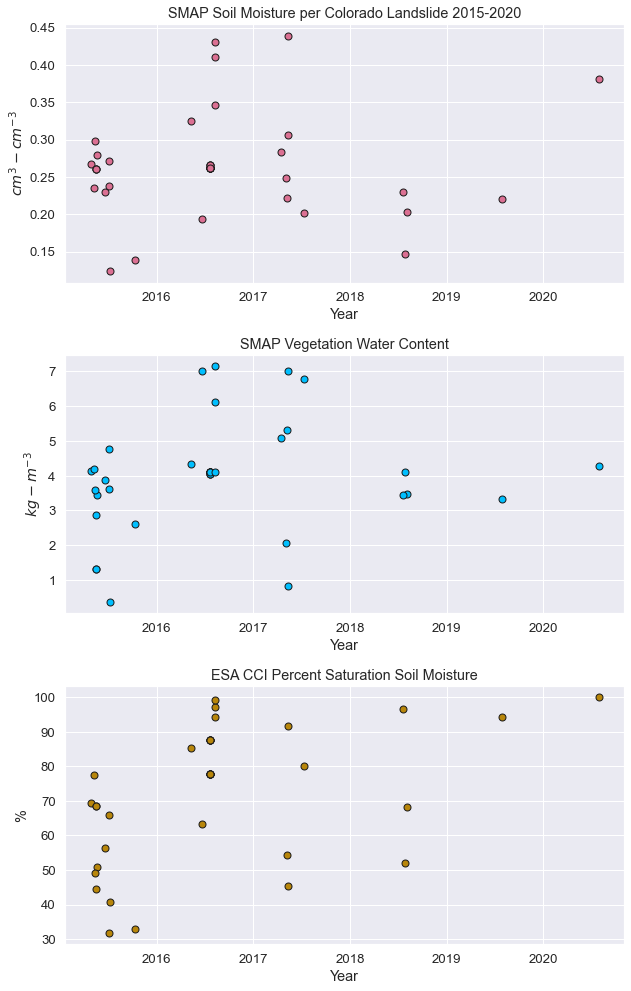

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(9, 14))

for id, df in landslide_df.groupby("landslide_id"):
    ax1.plot(df.index, df['smap_sm'],
            marker='o', linestyle='none', 
            mec='k', markersize=7.0, color='palevioletred')
    ax2.plot(df.index, df['veg_water_content'],
            marker='o', markersize=7.0, linestyle='none', 
            mec='k', color='deepskyblue')
    ax3.plot(df.index, df['esa_sm_percent'], 
            marker='o', linestyle='none', 
            mec='k', markersize=7.0, color='darkgoldenrod')

ax1.set(xlabel='Year',
       ylabel='$cm^3 - cm^{-3}$',
       title='SMAP Soil Moisture per '+state+' Landslide 2015-2020')

ax2.set(xlabel='Year',
       ylabel='$kg-m^{-3}$',
       title='SMAP Vegetation Water Content')

ax3.set(xlabel='Year',
       ylabel='%',
       title='ESA CCI Percent Saturation Soil Moisture')

plt.tight_layout()

output_fig = os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'soilmoisture_timeseries_'+state+'.png')

#output the figure
cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig);

### Plot the cumulative precipitation going back 7 days

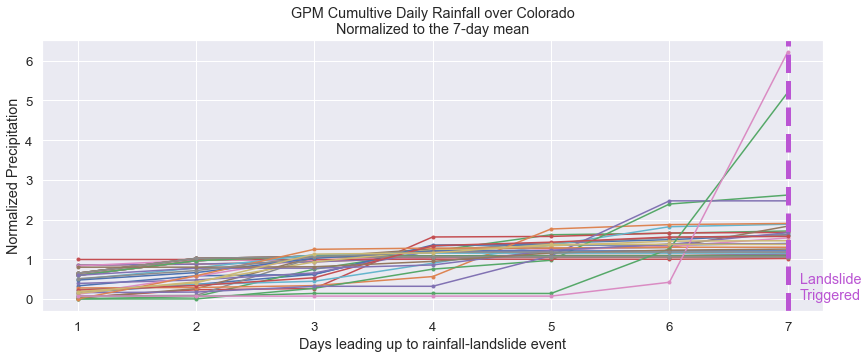

In [47]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in landslide_precip7d_df.groupby("landslide_id"):
    ax.plot(df['days-to-landslide'], 
            df['precip_accum_mm']/df['precip_accum_mm'].mean(), 
            marker='.')

#ax.invert_xaxis()
ax.axvline(x=7, ymin=0, color='mediumorchid', linestyle='dashed', linewidth=5)

ax.set(xlabel='Days leading up to rainfall-landslide event',
       ylabel='Normalized Precipitation',
       title='GPM Cumultive Daily Rainfall over '+state+'\nNormalized to the 7-day mean')
ax.text(7.1 ,0, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

#output the figure
output_precip = os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'gpm_precip7d_normalized_timeseries_'+state+'.png')

cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig);

### Plot Precipitation vs SMAP Soil Moisture

In [29]:
colors = ['red', 'green', 'orange', 'blue', 'cyan', 'purple']

category = dict(zip(np.unique(landslide_df['landslide_category']), colors))
print(category)

trigger = dict(zip(np.unique(landslide_df['landslide_trigger']), colors))
print(trigger)

{'debris_flow': 'red', 'landslide': 'green', 'mudslide': 'orange', 'rock_fall': 'blue'}
{'continuous_rain': 'red', 'downpour': 'green', 'rain': 'orange'}


#### Plot by Landslide Category

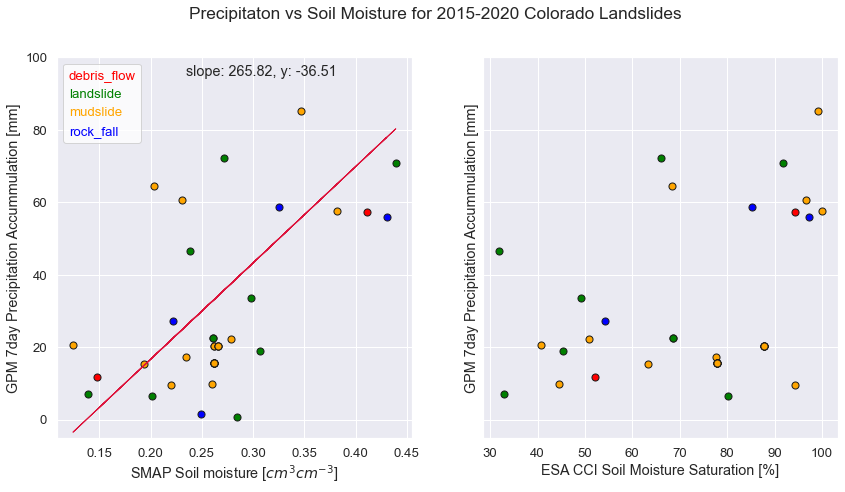

In [109]:
# Create a scatter plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 7),
                               sharey=True)

# SMAP
for id, df in landslide_df.groupby("landslide_id"):
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax1.scatter(df['smap_sm'], df['precip_accum_mm'],
                        edgecolor='k', s=50.0,
                        color=category[cat])
            ax2.scatter(df['esa_sm_percent'], df['precip_accum_mm'],
                        edgecolor='k', s=50.0,
                        color=category[cat])

# calculate the linear trend
idx = ( np.isfinite(landslide_df['smap_sm']) 
        & np.isfinite(landslide_df['precip_accum_mm'])
       )
# defining the variables
x = landslide_df['smap_sm'][idx].tolist()
y = landslide_df['precip_accum_mm'][idx].tolist()
# Calculate the OLR Bisector fit
intercept, slope, var = leastsq(x, y, method=3)
trend_mean_text = 'slope: '+str('{:.2f}'.format(slope)) + \
      ', y: '+str('{:.2f}'.format(intercept))

# plot the linear trend
ax1.plot(landslide_df['smap_sm'],
         intercept + slope*landslide_df['smap_sm'],
         color='crimson',
         linewidth=1.0)
ax1.text(x[0], 95, trend_mean_text)

ax1.set(xlabel='SMAP Soil moisture [$cm^3 cm^{-3}$]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')
ax1.set_ylim([-5, 100])

ax2.set(xlabel='ESA CCI Soil Moisture Saturation [%]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')

# Add legend
leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# add an overall caption
fig.suptitle(
    'Precipitaton vs Soil Moisture for 2015-2020 '+state+' Landslides'
)

# output the figure
output_fig = os.path.join(et.io.HOME,
                          'earth-analytics',
                          'capstone-landslides-soilmoisture', 'plots',
                          'sm_VS_precip_2015_2020_category_'+state+'.png')

cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig)

#### Plot by Landslide Trigger

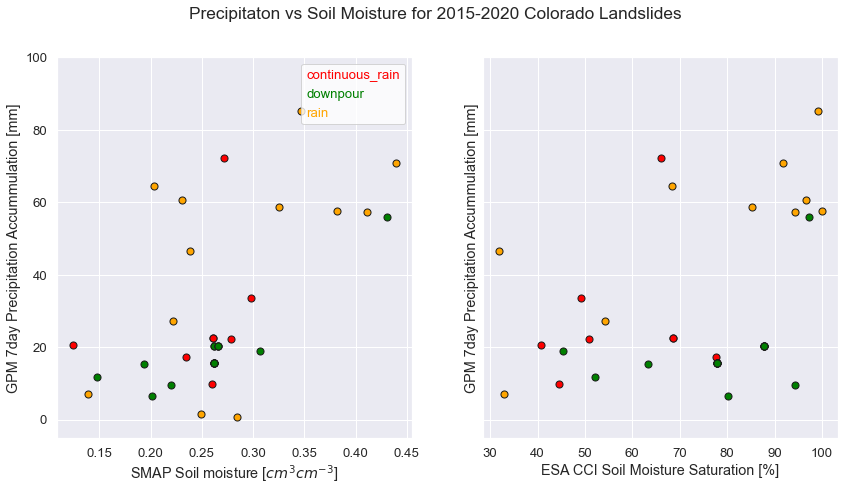

In [49]:
# Create a scatter plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 7),
                               sharey=True)

# SMAP
for id, df in landslide_df.groupby("landslide_id"):
    for cat in trigger:
        if df['landslide_trigger'][0] == cat:
            ax1.scatter(df['smap_sm'], df['precip_accum_mm'],
                        edgecolor='k', s=50.0,  
                        color=trigger[cat])
            ax2.scatter(df['esa_sm_percent'], df['precip_accum_mm'],
                        edgecolor='k', s=50.0,  
                        color=trigger[cat])

ax1.set(xlabel='SMAP Soil moisture [$cm^3 cm^{-3}$]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')
ax1.set_ylim([-5, 100])

ax2.set(xlabel='ESA CCI Soil Moisture Saturation [%]',
        ylabel='GPM 7day Precipitation Accummulation [mm]')

# Add legend
leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=trigger, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# add an overall caption
fig.suptitle(
    'Precipitaton vs Soil Moisture for 2015-2020 Colorado Landslides'
);

#output the figure
output_fig = os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'sm_VS_precip_2015_2020_trigger_'+state+'.png')

cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig);

### Plot Ratio of Normalize Precipitation to SMAP Soil Moisture
- By category and trigger

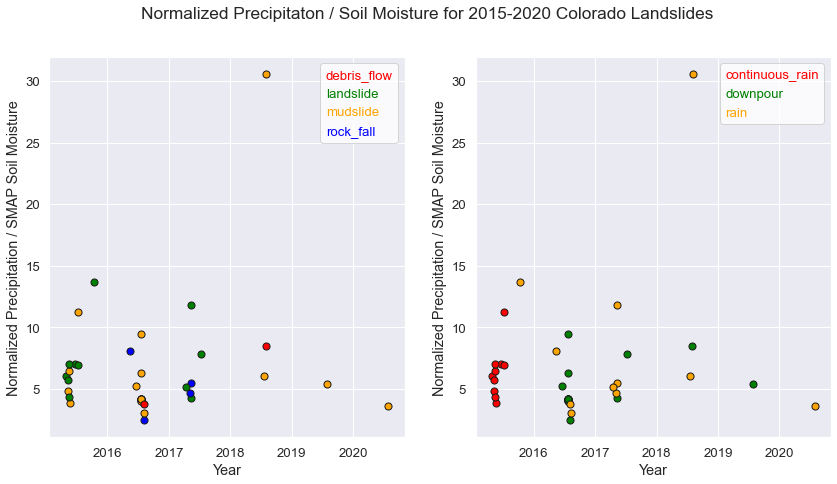

In [50]:
# Create a scatter plot
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 7))


# By Category
count = 1
for id, df in landslide_df.groupby("landslide_id"):
    for cat in category:
        if df['landslide_category'][0] == cat:
            ax1.scatter(df.index[0], df['precip_accum_norm']/df['smap_sm'],
                        edgecolor='k', s=50.0,  
                        color=category[cat])
    count = count+1

# Rotating X-axis labels
#ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)

ax1.set(xlabel='Year',
        ylabel='Normalized Precipitation / SMAP Soil Moisture')


# Add legend
leg = ax1.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=category, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)

# By Trigger
count = 1
for id, df in landslide_df.groupby("landslide_id"):
    for cat in trigger:
        if df['landslide_trigger'][0] == cat:
            ax2.scatter(df.index[0], df['precip_accum_norm']/df['smap_sm'],
                        edgecolor='k', s=50.0,  
                        color=trigger[cat])
    count = count+1

ax2.set(xlabel='Year',
        ylabel='Normalized Precipitation / SMAP Soil Moisture')

# Add legend
leg = ax2.legend(handlelength=0, handletextpad=0, fancybox=True,
                 labels=trigger, labelcolor=colors, facecolor='white')
for item in leg.legendHandles:
    item.set_visible(False)
    
# add an overall caption
fig.suptitle(
    'Normalized Precipitaton / Soil Moisture for 2015-2020 '+state+' Landslides'
);


### Look at outliers by creating box-whisker plots

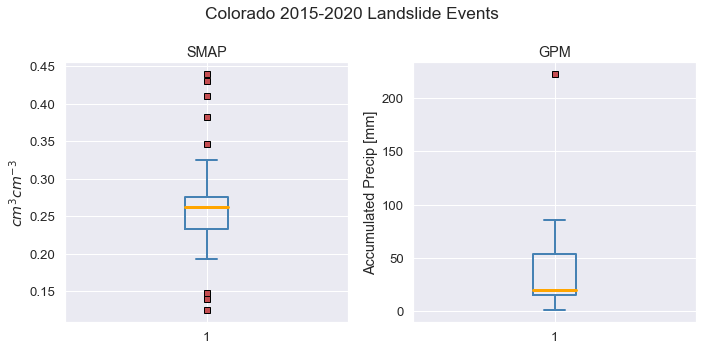

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

red_sqr = dict(markerfacecolor='r', marker='s')

# Data may contain NaN - these have to be removed for boxplot() to work
filtered_data = landslide_df['smap_sm'][~np.isnan(landslide_df['smap_sm'])]

axs[0].boxplot(filtered_data, flierprops=red_sqr,
              whiskerprops = dict(linestyle='-',linewidth=2., color='steelblue'),
              boxprops = dict(linestyle='-',linewidth=2., color='steelblue'),
              medianprops = dict(linestyle='-',linewidth=3., color='orange'),
              capprops = dict(linestyle='-',linewidth=2., color='steelblue')
              )
axs[0].set(title='SMAP',
          ylabel='$cm^3 cm^{-3}$')

filtered_data = landslide_df['precip_accum_mm'][~np.isnan(landslide_df['precip_accum_mm'])]
axs[1].boxplot(filtered_data, flierprops=red_sqr,
              whiskerprops = dict(linestyle='-',linewidth=2., color='steelblue'),
              boxprops = dict(linestyle='-',linewidth=2., color='steelblue'),
              medianprops = dict(linestyle='-',linewidth=3., color='orange'),
              capprops = dict(linestyle='-',linewidth=2., color='steelblue')
              )
axs[1].set(title='GPM',
          ylabel='Accumulated Precip [mm]')

plt.suptitle(state+' 2015-2020 Landslide Events')

plt.tight_layout()

output_fig = os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'sm_precip_2015_2020_boxplot_'+state+'.png')

#output the figure
cache_override = False or GLOBAL_CACHE_OVERRIDE
if not os.path.exists(output_fig) or cache_override:
    plt.savefig(output_fig);

In [20]:
# fly = box['fliers'][0]
# outliers = fly.get_ydata()
# outliers